In [ ]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

matches_path = "/content/matches.csv"
deliveries_path = "/content/deliveries.csv"

matches = pd.read_csv(matches_path)
deliveries = pd.read_csv(deliveries_path)

In [ ]:
# Handling Missing Values
matches.dropna(subset=['winner'], inplace=True)

# Feature Engineering
matches['date'] = pd.to_datetime(matches['date'])
matches['toss_match_winner'] = (matches['toss_winner'] == matches['winner']).astype(int)

**Team Performance Analysis**


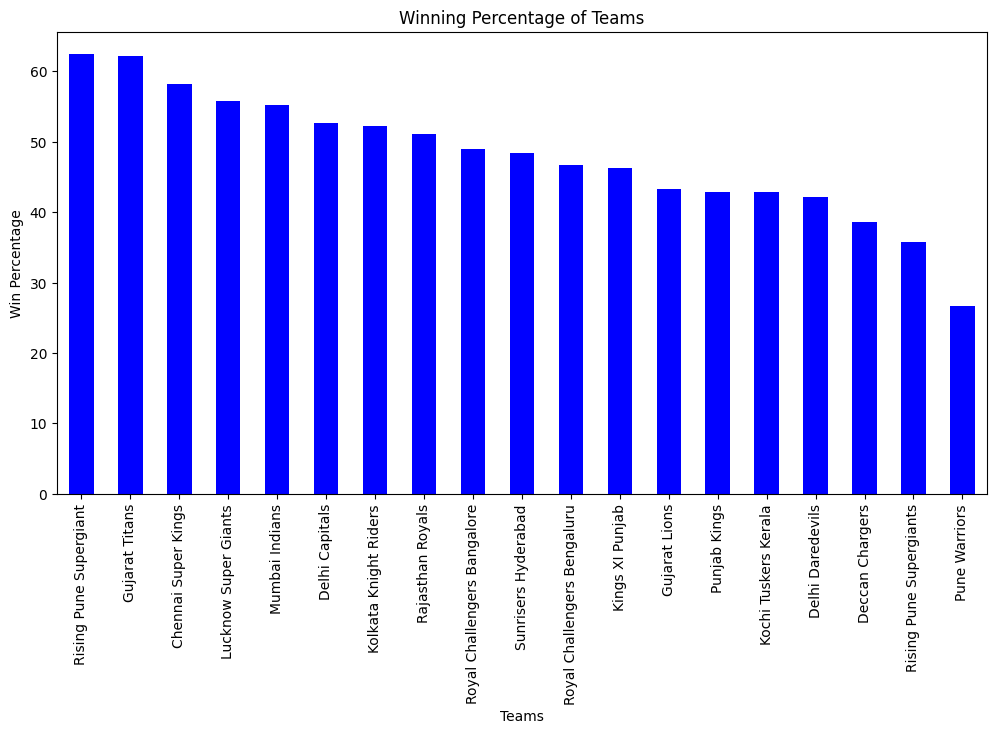

In [ ]:
match_counts = matches['team1'].value_counts() + matches['team2'].value_counts()
win_counts = matches['winner'].value_counts()
win_percentage = (win_counts / match_counts) * 100

plt.figure(figsize=(12, 6))
win_percentage.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title("Winning Percentage of Teams")
plt.ylabel("Win Percentage")
plt.xlabel("Teams")
plt.xticks(rotation=90)
plt.show()



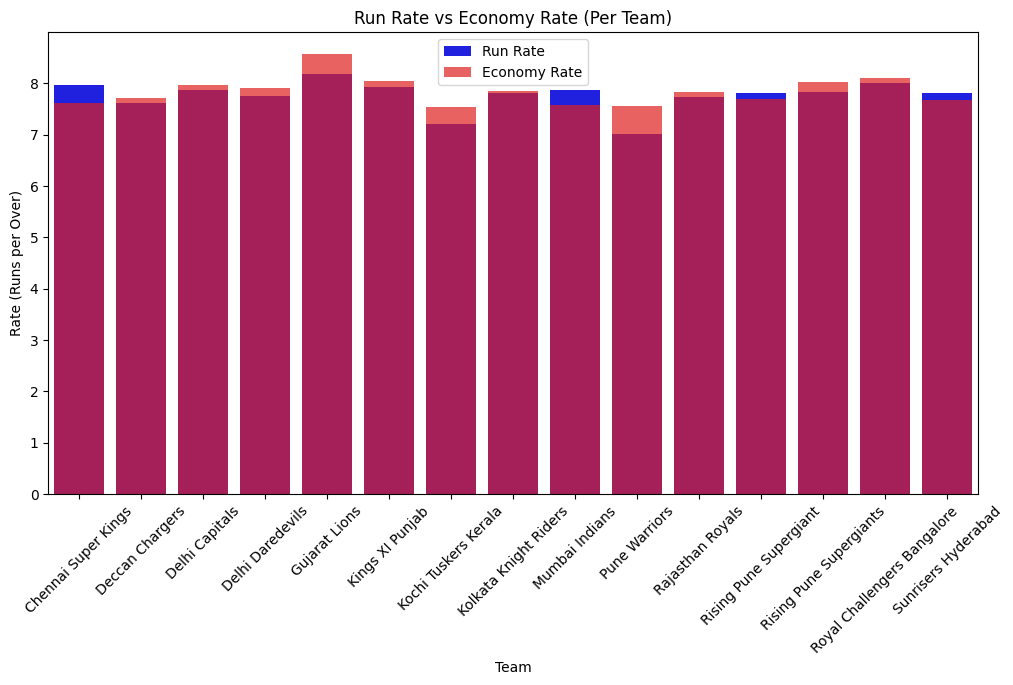

In [ ]:
# Calculating Total Runs Scored Per Team
total_runs_per_team = deliveries.groupby('batting_team')['total_runs'].sum()

# Calculating Total Overs Faced Per Team
total_balls_per_team = deliveries.groupby('batting_team')['over'].count()
total_overs_per_team = total_balls_per_team / 6  # Convert balls into overs

# Calculating Run Rate (Runs per Over)
run_rate = (total_runs_per_team / total_overs_per_team).reset_index()
run_rate.columns = ['Team', 'Run Rate']

# Calculating Total Runs Conceded Per Team (As Bowling Side)
runs_conceded_per_team = deliveries.groupby('bowling_team')['total_runs'].sum()

# Calculating Economy Rate (Runs Conceded per Over)
economy_rate = (runs_conceded_per_team / total_overs_per_team).reset_index()
economy_rate.columns = ['Team', 'Economy Rate']

# Merging Both DataFrames
rate_comparison = pd.merge(run_rate, economy_rate, on='Team')

# Ploting Run Rate & Economy Rate
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Run Rate', data=rate_comparison, color='blue', label="Run Rate")
sns.barplot(x='Team', y='Economy Rate', data=rate_comparison, color='red', label="Economy Rate", alpha=0.7)
plt.xticks(rotation=45)
plt.title("Run Rate vs Economy Rate (Per Team)")
plt.ylabel("Rate (Runs per Over)")
plt.xlabel("Team")
plt.legend()
plt.show()


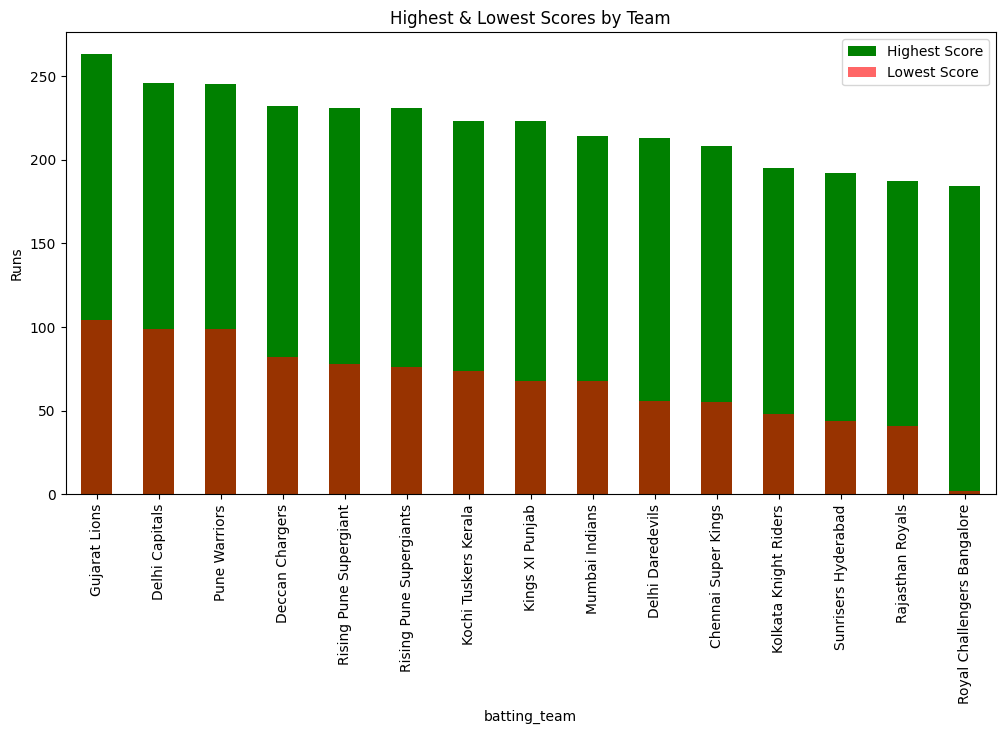

In [ ]:
# Highest & Lowest Team Scores
team_scores = deliveries.groupby(["match_id", "batting_team"])["total_runs"].sum().reset_index()
highest_scores = team_scores.groupby("batting_team")["total_runs"].max()
lowest_scores = team_scores.groupby("batting_team")["total_runs"].min()

# Plot
plt.figure(figsize=(12, 6))
highest_scores.sort_values(ascending=False).plot(kind="bar", color="green", label="Highest Score")
lowest_scores.sort_values(ascending=False).plot(kind="bar", color="red", alpha=0.6, label="Lowest Score")
plt.xticks(rotation=90)
plt.title("Highest & Lowest Scores by Team")
plt.ylabel("Runs")
plt.legend()
plt.show()


**Player Performance Analysis**

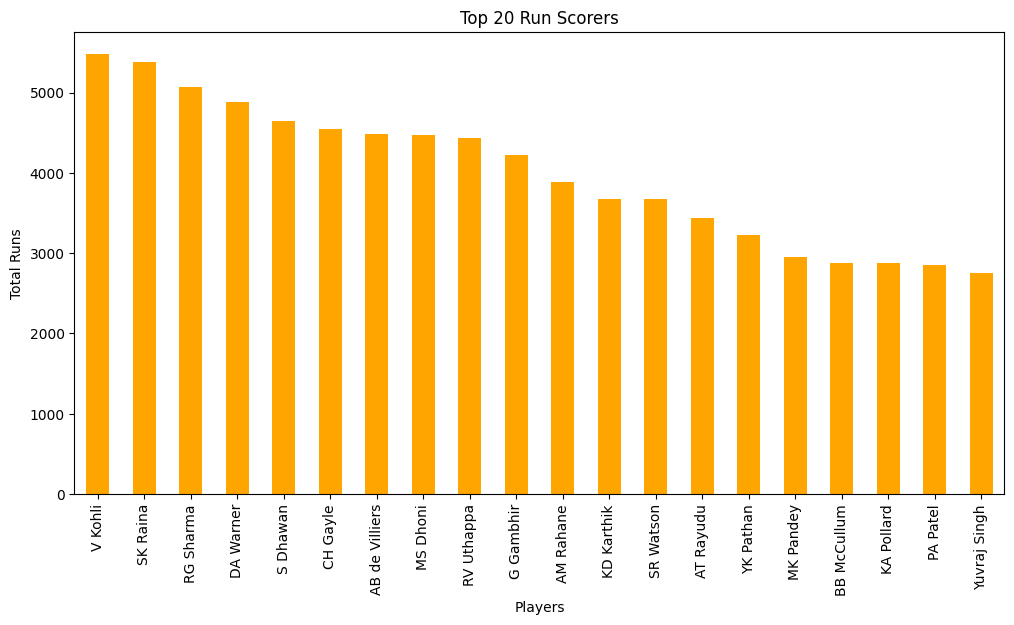

In [ ]:
#Top 20 Run Scorers
top_scorers = deliveries.groupby("batter")["batsman_runs"].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
top_scorers.plot(kind='bar', color='orange')
plt.title("Top 20 Run Scorers")
plt.ylabel("Total Runs")
plt.xlabel("Players")
plt.xticks(rotation=90)
plt.show()

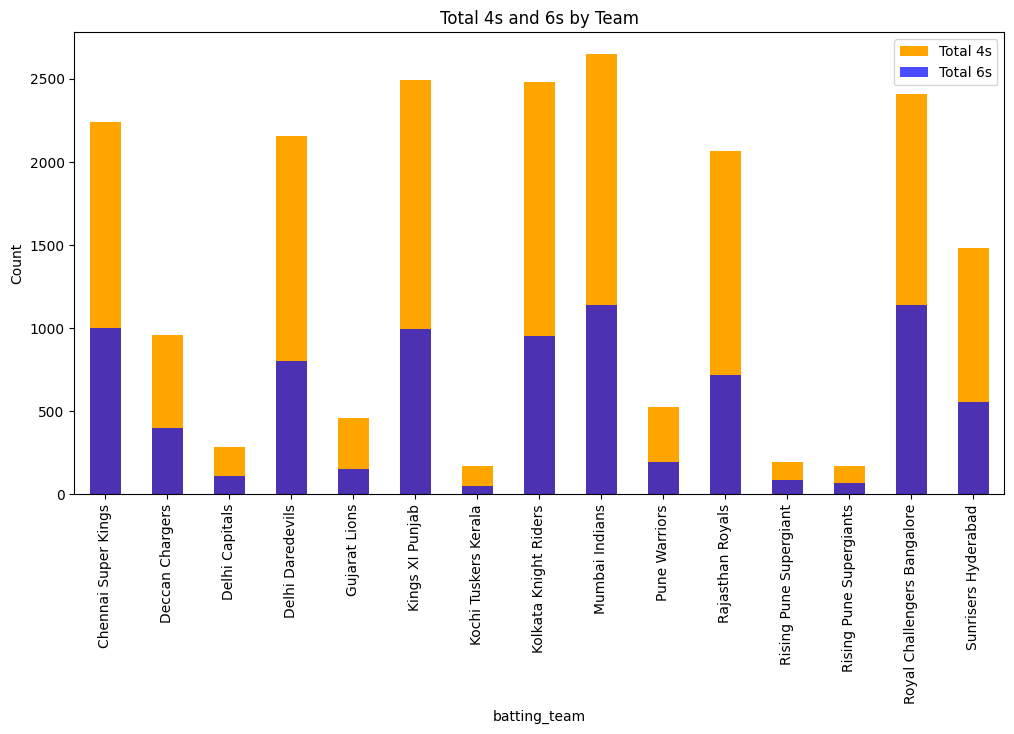

In [ ]:
fours = deliveries[deliveries["batsman_runs"] == 4].groupby("batting_team")["batsman_runs"].count()
sixes = deliveries[deliveries["batsman_runs"] == 6].groupby("batting_team")["batsman_runs"].count()

plt.figure(figsize=(12, 6))
fours.plot(kind="bar", color="orange", label="Total 4s")
sixes.plot(kind="bar", color="blue", alpha=0.7, label="Total 6s")
plt.xticks(rotation=90)
plt.title("Total 4s and 6s by Team")
plt.ylabel("Count")
plt.legend()
plt.show()


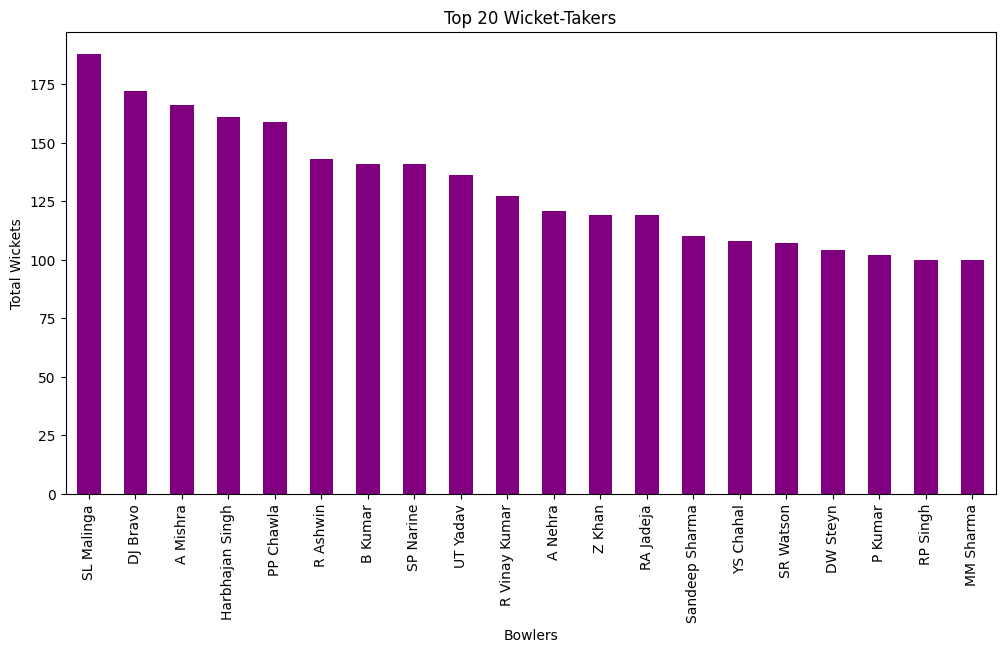

In [ ]:
top_wickets = deliveries[deliveries["is_wicket"] == 1].groupby("bowler")["is_wicket"].count().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 6))
top_wickets.plot(kind='bar', color='purple')
plt.title("Top 20 Wicket-Takers")
plt.ylabel("Total Wickets")
plt.xlabel("Bowlers")
plt.xticks(rotation=90)
plt.show()

<ipython-input-9-eef5cc9c2447>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  batsman_stats["Batting Average"].replace([float("inf"), np.nan], 0, inplace=True)  # Replace division by zero errors


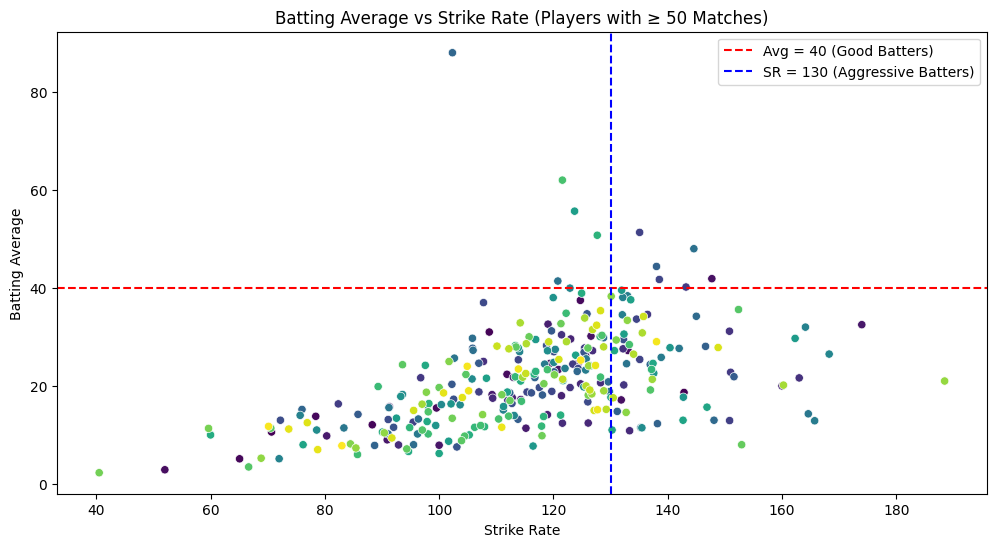

In [ ]:
#Batting Average vs Strike Rate
# Merge season information into deliveries dataset
deliveries_with_season = deliveries.merge(matches[['id', 'season']], left_on='match_id', right_on='id', how='left')

# Calculate Total Runs Scored & Balls Faced Per Player
batsman_stats = deliveries.groupby("batter").agg(
    total_runs=("batsman_runs", "sum"),
    total_balls=("batsman_runs", "count"),  # Counting all deliveries faced
    total_dismissals=("is_wicket", "sum")  # Counting times the batsman got out
).reset_index()

# Calculate Batting Average
batsman_stats["Batting Average"] = batsman_stats["total_runs"] / batsman_stats["total_dismissals"]
batsman_stats["Batting Average"].replace([float("inf"), np.nan], 0, inplace=True)  # Replace division by zero errors

# Calculate Batting Strike Rate
batsman_stats["Strike Rate"] = (batsman_stats["total_runs"] / batsman_stats["total_balls"]) * 100

# Filter Players Who Played at Least 50 Matches
players_above_50_matches = deliveries["batter"].value_counts()
valid_players = players_above_50_matches[players_above_50_matches >= 50].index
filtered_batsmen = batsman_stats[batsman_stats["batter"].isin(valid_players)]

# Plot Batting Average vs Strike Rate
plt.figure(figsize=(12, 6))
sns.scatterplot(x=filtered_batsmen["Strike Rate"], y=filtered_batsmen["Batting Average"], hue=filtered_batsmen["batter"], palette="viridis", legend=False)
plt.title("Batting Average vs Strike Rate (Players with ≥ 50 Matches)")
plt.xlabel("Strike Rate")
plt.ylabel("Batting Average")
plt.axhline(y=40, color='red', linestyle='--', label="Avg = 40 (Good Batters)")
plt.axvline(x=130, color='blue', linestyle='--', label="SR = 130 (Aggressive Batters)")
plt.legend()
plt.show()



**Seasonal Analysis**

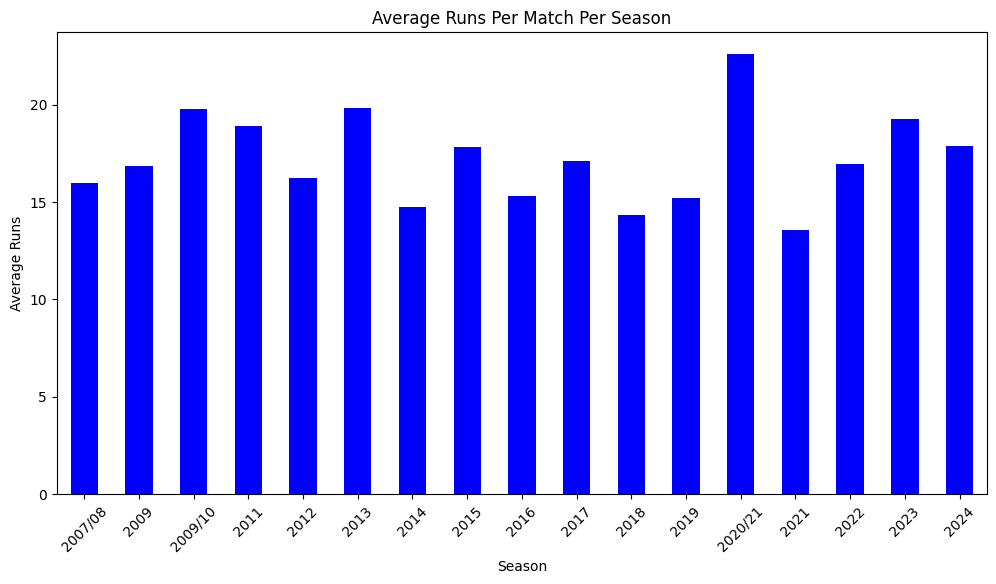

In [ ]:
season_avg_runs = matches.groupby("season")["result_margin"].mean()
plt.figure(figsize=(12, 6))
season_avg_runs.plot(kind="bar", color="blue")
plt.title("Average Runs Per Match Per Season")
plt.ylabel("Average Runs")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.show()



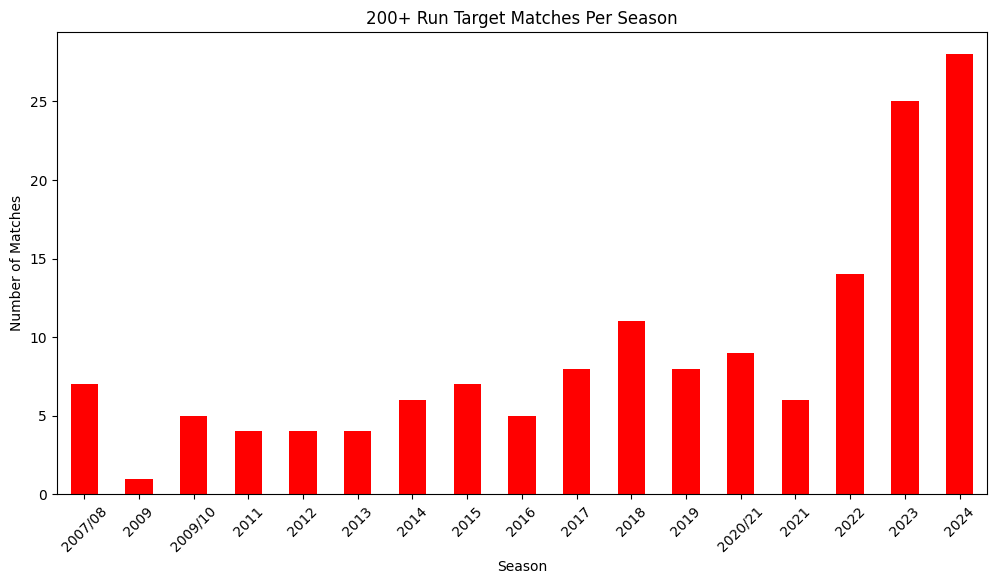

In [ ]:
 #200+ Target Matches Per Season
high_scores = matches[matches["target_runs"] >= 200].groupby("season")["id"].count()
plt.figure(figsize=(12, 6))
high_scores.plot(kind="bar", color="red")
plt.title("200+ Run Target Matches Per Season")
plt.ylabel("Number of Matches")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.show()

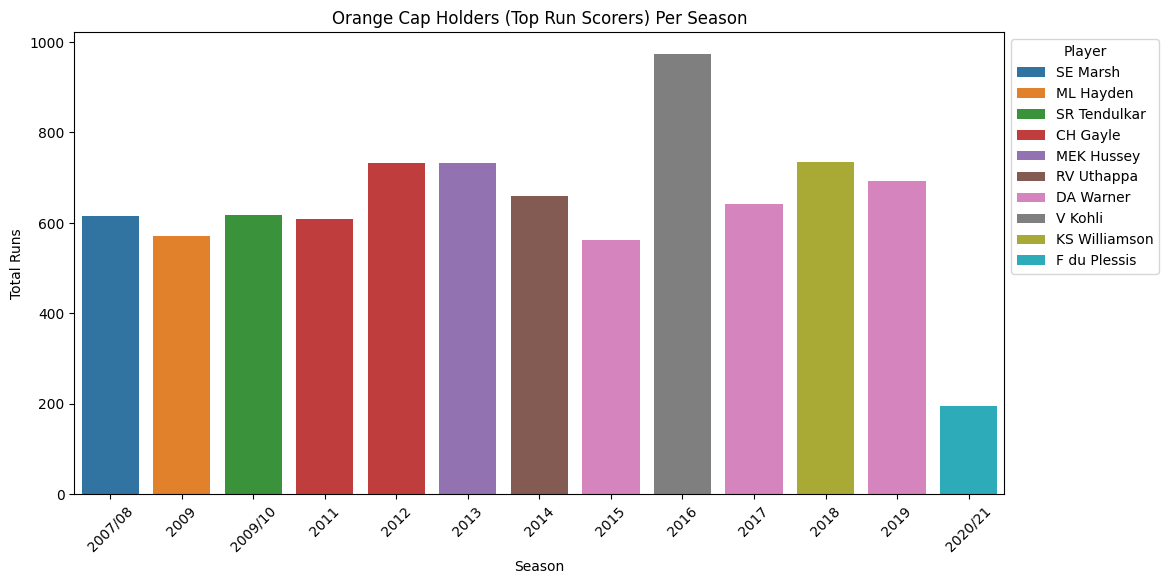

In [ ]:
# Merge season information from matches dataset into deliveries
deliveries_with_season = deliveries.merge(matches[['id', 'season']], left_on='match_id', right_on='id', how='left')

# Group by season and batter to sum total runs
top_run_scorers_per_season = deliveries_with_season.groupby(['season', 'batter'])['batsman_runs'].sum().reset_index()

# Find the top scorer for each season
orange_cap = top_run_scorers_per_season.loc[top_run_scorers_per_season.groupby('season')['batsman_runs'].idxmax()]

# Plot Orange Cap Holders
plt.figure(figsize=(12, 6))
sns.barplot(x=orange_cap["season"], y=orange_cap["batsman_runs"], hue=orange_cap["batter"])
plt.title("Orange Cap Holders (Top Run Scorers) Per Season")
plt.ylabel("Total Runs")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.legend(title="Player", bbox_to_anchor=(1,1))
plt.show()


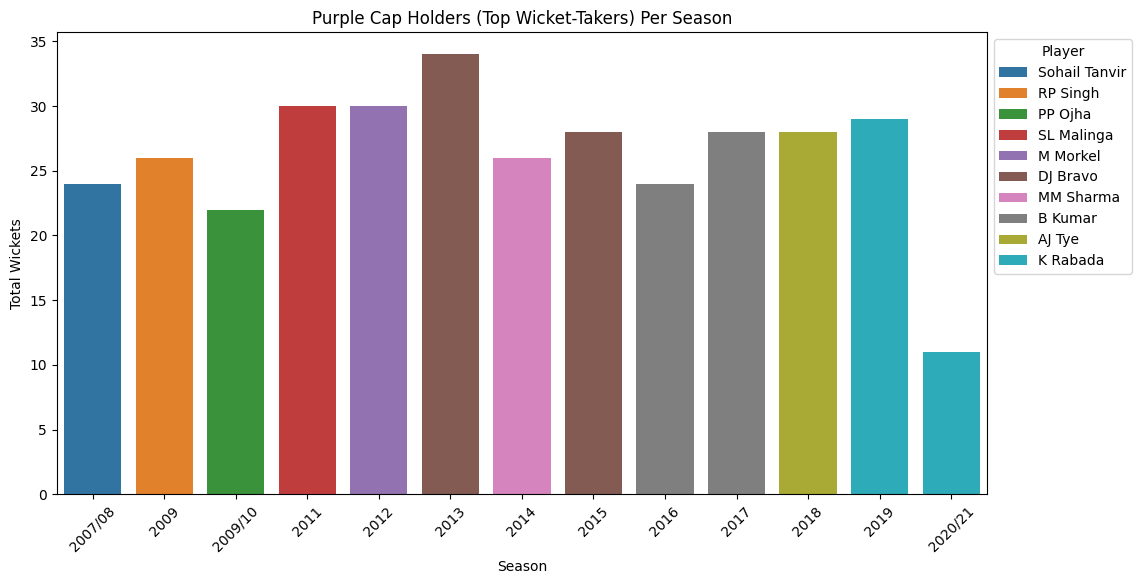

In [ ]:
# Merge season information from matches dataset into deliveries
deliveries_with_season = deliveries.merge(matches[['id', 'season']], left_on='match_id', right_on='id', how='left')

# Filter only valid wicket-taking deliveries
valid_wickets = deliveries_with_season[deliveries_with_season["is_wicket"] == 1]

# Group by season and bowler to count total wickets
top_wicket_takers_per_season = valid_wickets.groupby(['season', 'bowler'])['is_wicket'].count().reset_index()

# Find the highest wicket-taker for each season
purple_cap = top_wicket_takers_per_season.loc[top_wicket_takers_per_season.groupby('season')['is_wicket'].idxmax()]

# Plot Purple Cap Holders
plt.figure(figsize=(12, 6))
sns.barplot(x=purple_cap["season"], y=purple_cap["is_wicket"], hue=purple_cap["bowler"])
plt.title("Purple Cap Holders (Top Wicket-Takers) Per Season")
plt.ylabel("Total Wickets")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.legend(title="Player", bbox_to_anchor=(1,1))
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical team names into numeric values
label_enc = LabelEncoder()
for col in ['team1', 'team2', 'toss_winner', 'winner']:  # Encoding categorical columns
    matches[col] = label_enc.fit_transform(matches[col])

# Now proceed with splitting the dataset
features = ['team1', 'team2', 'toss_winner', 'toss_match_winner']
target = 'winner'

X = matches[features]
y = matches[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

def train_models(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)

    return rf, gb, xgb

rf, gb, xgb = train_models(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

print("Random Forest Model:")
evaluate_model(rf, X_test, y_test)

print("Gradient Boosting Model:")
evaluate_model(gb, X_test, y_test)

print("XGBoost Model:")
evaluate_model(xgb, X_test, y_test)


Random Forest Model:
Accuracy: 0.8623853211009175
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00         2
           2       0.60      0.43      0.50         7
           3       0.77      0.77      0.77        13
           4       0.75      0.60      0.67         5
           5       0.71      0.56      0.62         9
           6       0.63      1.00      0.77        17
           7       0.00      0.00      0.00         2
           8       0.90      0.83      0.86        23
           9       1.00      0.67      0.80         3
          10       0.93      1.00      0.96        26
          11       0.50      0.33      0.40         3
          12       1.00      0.67      0.80         3
          13       0.86      0.96      0.91        25
          14       1.00      0.50      0.67         4
          16       0.92      0.92      0.92        26
          17       0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Encode the hypothetical teams
new_data = pd.DataFrame({
    'team1': [label_enc.transform(['Mumbai Indians'])[0]],
    'team2': [label_enc.transform(['Chennai Super Kings'])[0]],
    'toss_winner': [label_enc.transform(['Mumbai Indians'])[0]],
    'toss_match_winner': [1]
})

winner_pred = xgb.predict(new_data)
predicted_winner = label_enc.inverse_transform([winner_pred[0]])[0]
print("Predicted IPL 2025 Winner:", predicted_winner)


Predicted IPL 2025 Winner: Mumbai Indians
